# Sandbox for looking at output of trained UResNet 

In [1]:
import os,sys,time
import ROOT
from ROOT import std
from larcv import larcv
import numpy as np

# torch
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn.functional as F

# Our model definition
#from uresnet import UResNet
from caffe_uresnet import UResNet

%matplotlib notebook
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.12/04


In [2]:
# Set GPU ID
GPUMODE=True
GPUID=1
torch.cuda.device(1)

## Setup Network

In [3]:
# create instance
net = UResNet(inplanes=16,input_channels=1,num_classes=3)

numclasses = 4 # (bg, shower, track, noise)                                                                                                                                                  
net.conv11 = nn.Conv2d(net.inplanes, numclasses, kernel_size=7, stride=1, padding=3, bias=True )
if GPUMODE:
    net.cuda(GPUID)

In [4]:
# load weights
#weightfile="checkpoint_p2_caffe/checkpoint.30000th.tar" # plane 0 trained on pbomb
weightfile="checkpoint.8000th.tar" # plane 0, cosmic trained

checkpoint = torch.load( weightfile )
net.load_state_dict(checkpoint["state_dict"])


## Setup Image IO

In [5]:
# Define IO Class

# Segment Image Data Class
# we expect LArCV1Dataset to fill this object
class SegData:
    def __init__(self):
        self.dim = None
        self.images = None # adc image
        self.labels = None # labels
        self.weights = None # weights
        return

    def shape(self):
        if self.dim is None:
            raise ValueError("SegData instance hasn't been filled yet")
        return self.dim

# Data interface
class LArCV1Dataset:
    def __init__(self, name, channels=[0,1,2] ):
        # inputs
        # cfgfile: path to configuration. see test.py.ipynb for example of configuration
        self.name = name
        self.channels = channels
        return
      
    def init(self,inputfile, imgproducer ):
        # create instance of data file interface
        self.io = larcv.IOManager()
        self.io.add_in_file( inputfile )
        self.io.initialize()
        self.nentries = self.io.get_n_entries()
        self.ientry = 0
        self.io.read_entry(self.ientry)
        # we read the first entry to get the image size
        self.imgproducer = imgproducer
        ev_data = self.io.get_data( larcv.kProductImage2D, imgproducer )
        self.nchannels = ev_data.Image2DArray().size()
        self.height    = ev_data.Image2DArray().front().meta().rows()
        self.width     = ev_data.Image2DArray().front().meta().cols()
        self.dimv = std.vector("int")(3)
        self.dimv[0] = len(self.channels)
        self.dimv[1] = self.height
        self.dimv[2] = self.width
        print "[LArCV1Dataset] able to create IOManager"
        return
        
    def getbatch(self, batchsize):
        
        
        # fill SegData object
        data = SegData()
        self.dim     = (batchsize, len(self.channels), self.dimv[1], self.dimv[2] )
        self.dim3    = (len(self.channels), self.dimv[1], self.dimv[2] )

        # numpy arrays
        data.np_images  = np.zeros( self.dim,  dtype=np.float32 )
        data.np_labels  = np.zeros( self.dim3, dtype=np.int )
        data.np_weights = np.zeros( self.dim3, dtype=np.float32 )
        for ibatch in range(batchsize):
            self.io.read_entry(self.ientry)
            self.ientry+=1
            if self.ientry>=self.nentries:
                self.ientry = 0
            ev_data = self.io.get_data( larcv.kProductImage2D, self.imgproducer )
            for n,c in enumerate(self.channels):
                img = ev_data.Image2DArray().at(c)
                img_np = np.transpose(larcv.as_ndarray(img),[1,0])
                data.np_images[ibatch,n,:]  = img_np[:]
                data.np_labels  = np.zeros( img_np.shape )
                data.np_weights = np.zeros( img_np.shape )
                
                data.np_images[ data.np_images<10 ] = 0
        
        # pytorch tensors
        data.images = torch.from_numpy(data.np_images)
        data.labels = torch.from_numpy(data.np_labels)
        data.weight = torch.from_numpy(data.np_weights)
        #if GPUMODE:
        #    data.images.cuda()
        #    data.labels.cuda(async=False)
        #    data.weight.cuda(async=False)


        # debug values
        #print "max label: ",np.max(data.labels)
        #print "min label: ",np.min(data.labels)
        
        return data

In [6]:
inputfile = "/home/twongj01/baka_larcv.root"
io = LArCV1Dataset("test",[0])
io.init(inputfile,"adc")


[LArCV1Dataset] able to create IOManager
    [NORMAL]  <IOManager::prepare_input> Opening a file in READ mode: /home/twongj01/baka_larcv.root
    [NORMAL]  <IOManager::initialize> Prepared input with 36 entries...


## Run Network

In [7]:
# Get batch
io.ientry=15
batch = io.getbatch(5)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.


In [8]:
# convert images into pytorch variables, then pass to net

if GPUMODE:
    img_var = torch.autograd.Variable(batch.images.cuda(GPUID))
else:
    img_var = torch.autograd.Variable(batch.images)
out_var = net(img_var)

In [9]:
# turn output into labels (transfer back from gpu if necesary)

out_np = out_var.data.cpu().numpy()
decision_np = np.argmax( out_np, axis=1 )


# Plotting

In [10]:
# function for plotting side-by-side

def showImgAndLabels(image2d,decision):
    # Dump images
    fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(10,10), facecolor='w')
    ax0.imshow(image2d,  interpolation='none', cmap='jet', origin='lower')
    ax0.set_title('Data',fontsize=20,fontname='Georgia',fontweight='bold')
    ax1.imshow(decision, interpolation='none', cmap='jet', origin='lower',vmin=0., vmax=4.1)
    ax1.set_title('Network Out',fontsize=20,fontname='Georgia',fontweight='bold')
    plt.show()

<IPython.core.display.Javascript object>


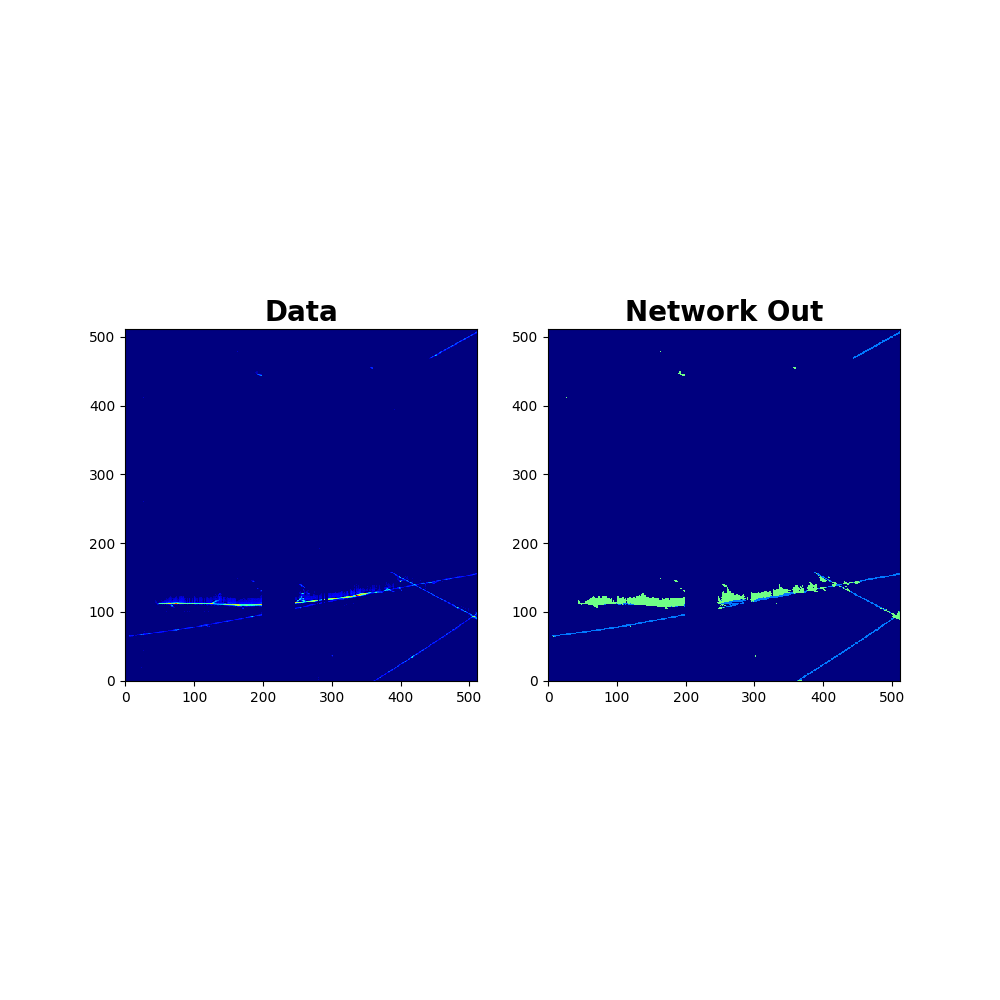

<IPython.core.display.Javascript object>


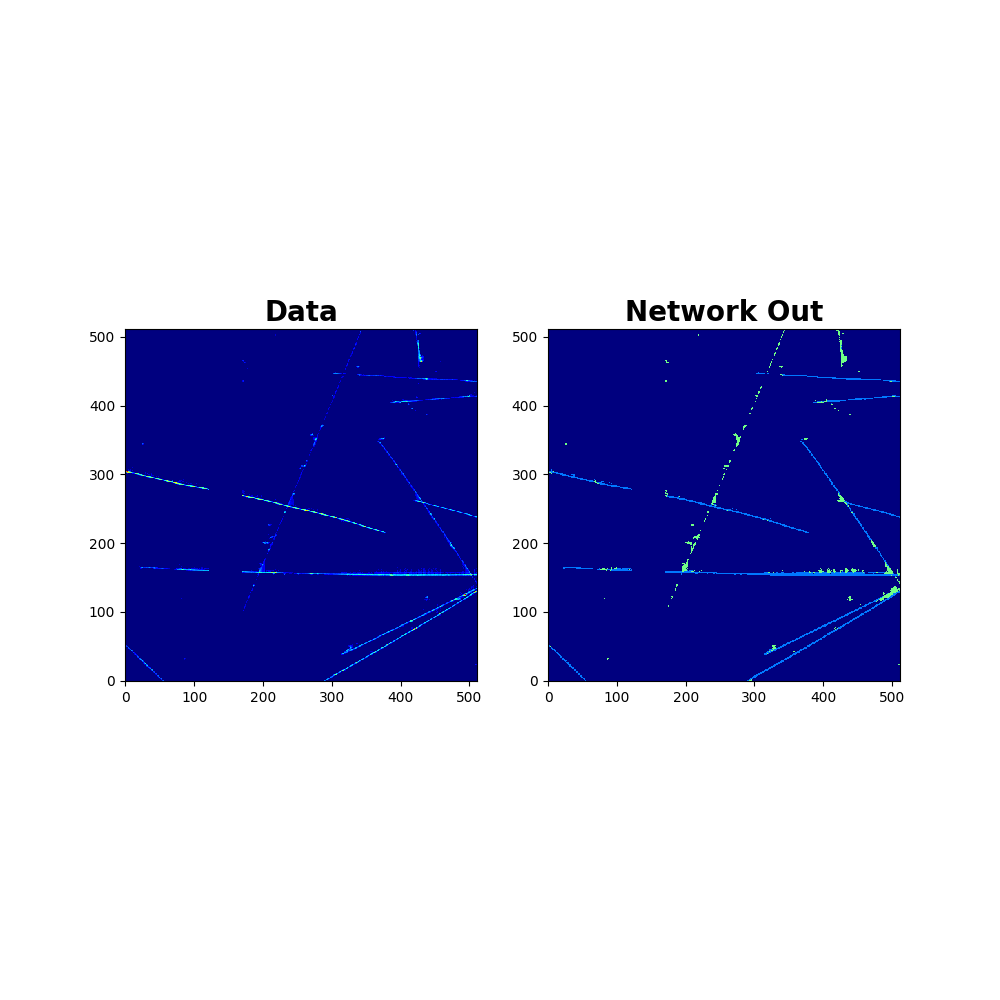

<IPython.core.display.Javascript object>


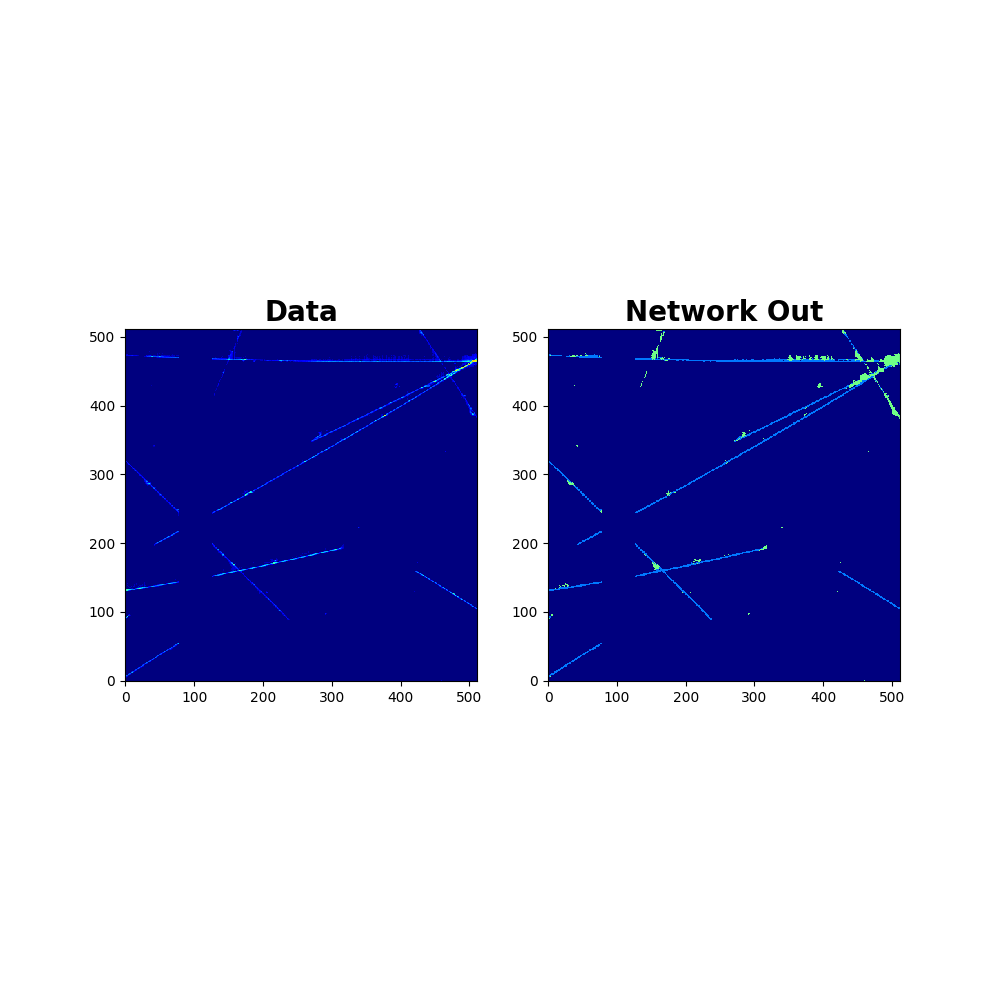

<IPython.core.display.Javascript object>


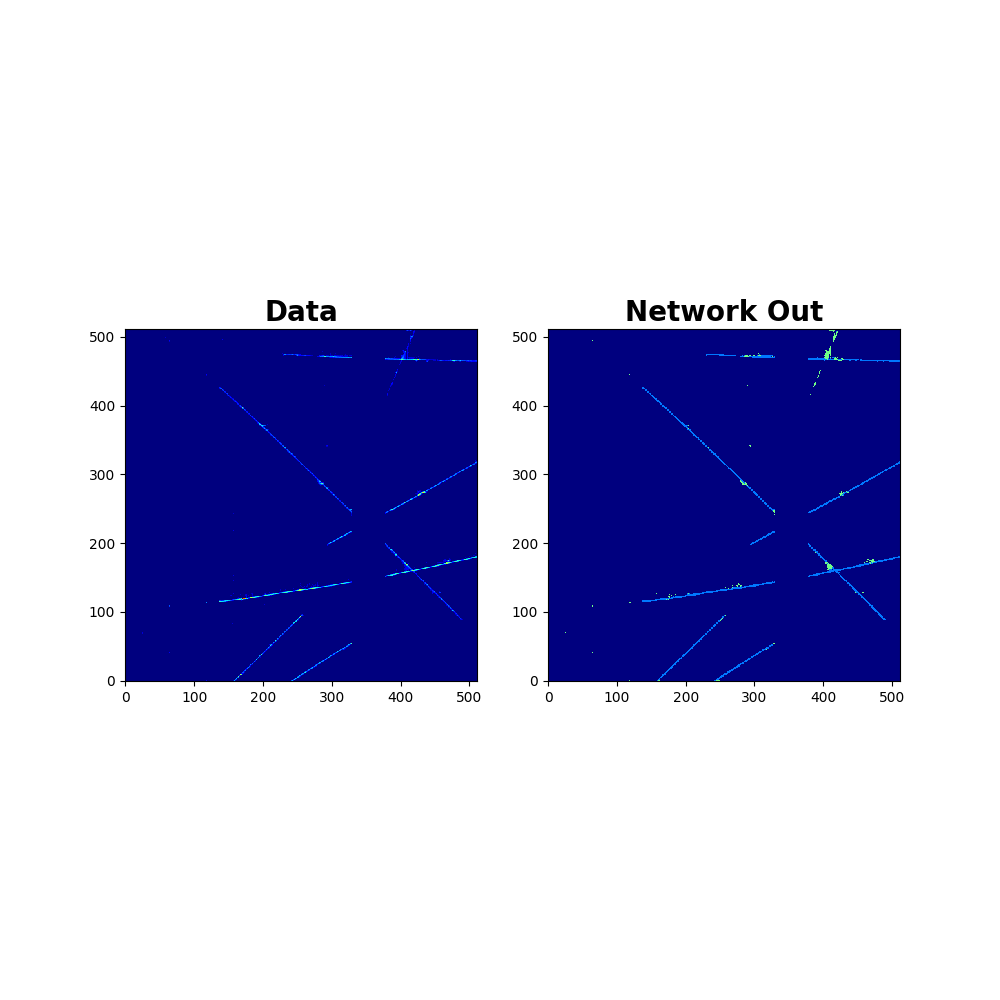

<IPython.core.display.Javascript object>


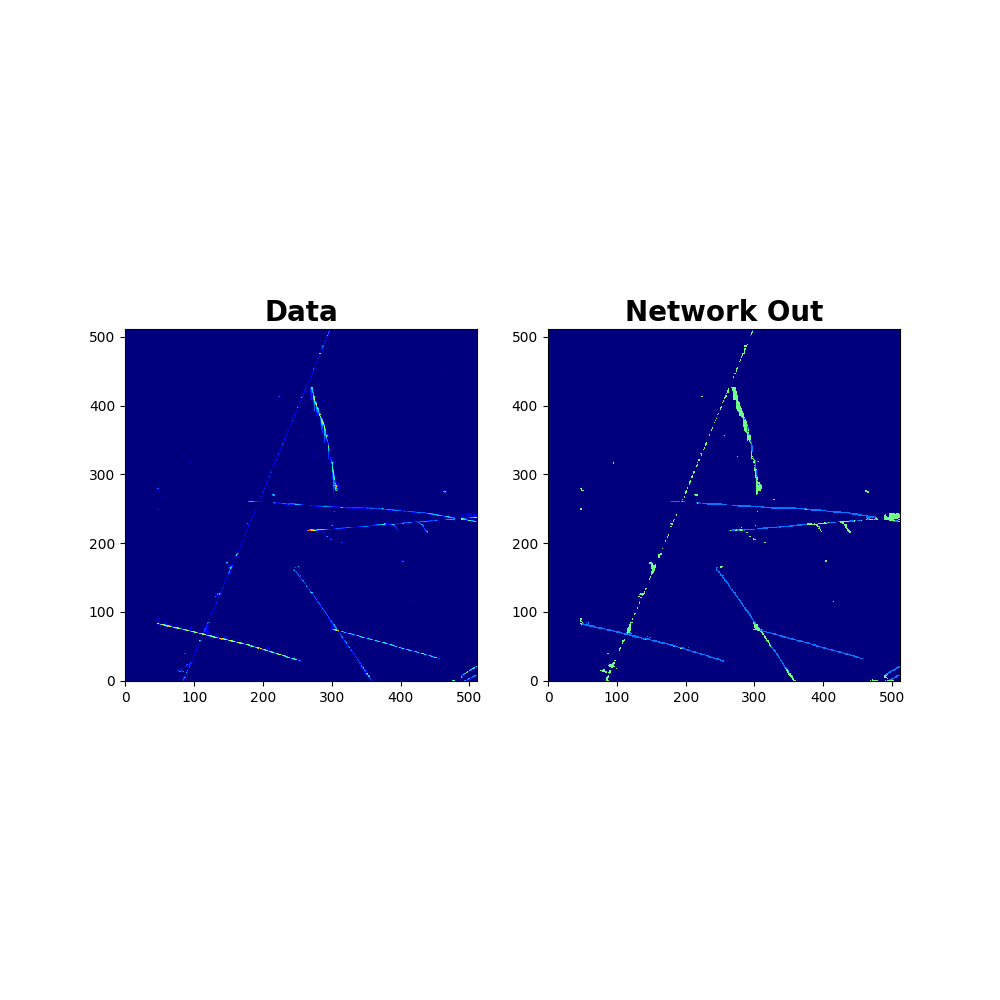

In [11]:
for ibatch in range(out_var.shape[0]):
    img_np = batch.images.cpu().numpy()[ibatch,0,:,:]
    showImgAndLabels(img_np,decision_np[ibatch,:,:])